In [ ]:
import torch
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision.datasets

In [ ]:
random.seed(18)
np.random.seed(18)
torch.manual_seed(18)      
torch.cuda.manual_seed(18) 
torch.backends.cudnn.deterministic = True  

In [ ]:
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

In [ ]:
X_train = MNIST_train.data
X_test = MNIST_test.data
y_train = MNIST_train.targets
y_test = MNIST_test.targets

In [ ]:
X_train.dtype, y_train.dtype, X_test.dtype, y_test.dtype

(torch.uint8, torch.int64, torch.uint8, torch.int64)

In [ ]:
X_train = X_train.float()
X_test = X_test.float()

In [ ]:
X_train.shape, X_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [ ]:
y_train.shape, y_test.shape

(torch.Size([60000]), torch.Size([10000]))

In [ ]:
X_train = X_train.unsqueeze(1)
X_test = X_test.unsqueeze(1)

In [ ]:
X_train.shape, X_test.shape

(torch.Size([60000, 1, 28, 28]), torch.Size([10000, 1, 28, 28]))

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
X_test = X_test.to(device)
y_test = y_test.to(device)

# БАЗОВАЯ МОДЕЛЬ

In [ ]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1 = torch.nn.Tanh()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2 = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.fc1 = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3 = torch.nn.Tanh()
        
        self.fc2 = torch.nn.Linear(120, 84)
        self.act4 = torch.nn.Tanh()
        
        self.fc3 = torch.nn.Linear(84, 10)
        
    def forward(self, x): 
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)   
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)   

        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x

In [ ]:
def train_model(net, X_train, loss, optimizer, n_epoch=50, batch_size=100):
  test_accuracy_history = []
  test_loss_history = []
  for epoch in range(n_epoch):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()

        X_batch = X_train[start_index:start_index+batch_size].to(device)
        y_batch = y_train[start_index:start_index+batch_size].to(device)
        
        preds = net.forward(X_batch)
        
        loss_val = loss(preds, y_batch)
        loss_val.backward()
        
        optimizer.step()

    test_preds = net.forward(X_test)

    test_loss = loss(test_preds, y_test).data.cpu()
    test_loss_history.append(test_loss)

    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)
   
  model_results = pd.DataFrame(
      {'accuracy':[float(i) for i in test_accuracy_history], 
       'loss':[float(j) for j in test_loss_history]})
  return model_results
   

In [ ]:
model = LeNet5().to(device)
loss = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
base_model_results = train_model(model, X_train, loss, optimizer)

In [ ]:
f'Максимальная точность достигается на {base_model_results.accuracy.idxmax()} эпохе и составляет {base_model_results.accuracy.max()}'

'Максимальная точность достигается на 28 эпохе и составляет 0.9896999597549438'

In [ ]:
f'Соответственно минимум функции потерь на {base_model_results.loss.idxmin()} эпохе составляет {base_model_results.loss.min()}'

'Соответственно минимум функции потерь на 28 эпохе составляет 0.04320123419165611'

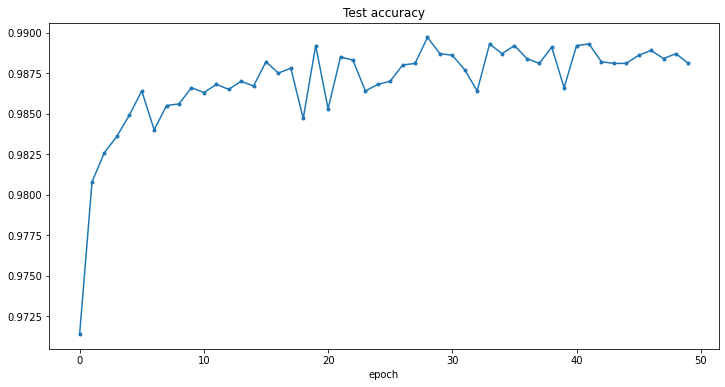

In [ ]:
plt.figure(figsize=(12,6))
plt.title('Test accuracy')
plt.xlabel('epoch')
plt.plot(base_model_results.accuracy, marker='.');

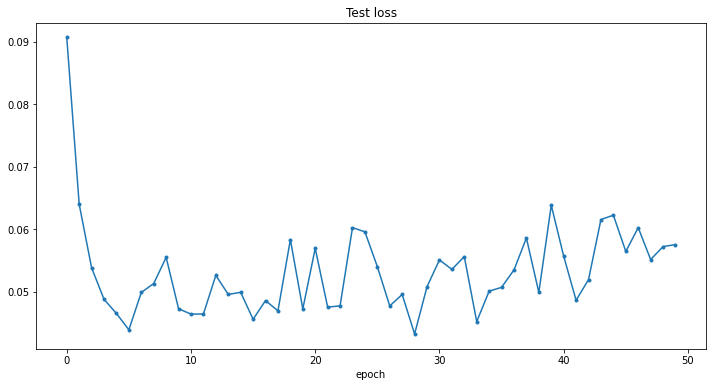

In [ ]:
plt.figure(figsize=(12,6))
plt.title('Test loss')
plt.xlabel('epoch')
plt.plot(base_model_results.loss, marker='.');

# МОДИФИЦИРОВАННАЯ МОДЕЛЬ
- заменим функции активации Tahn() на ReLU()
- заменим AvgPool на MaxPool
- вместо свертки 5x5 применим две последовательные свертки 3x3 

In [51]:
class LeNetM(torch.nn.Module):
    def __init__(self):
        super(LeNetM, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, padding=1)
        self.act1 = torch.nn.ReLU()
        self.conv11 = torch.nn.Conv2d(in_channels=6, out_channels=6, kernel_size=3, padding=1)
        self.act11 = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=18, kernel_size=3, padding=1)
        self.act2 = torch.nn.ReLU()
        self.conv22 = torch.nn.Conv2d(in_channels=18, out_channels=18, kernel_size=3, padding=1)
        self.act22 = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = torch.nn.Linear(7 * 7 * 18, 120)
        self.act3 = torch.nn.ReLU()
        
        self.fc2 = torch.nn.Linear(120, 84)
        self.act4 = torch.nn.ReLU()

        self.fc3 = torch.nn.Linear(84, 36)
        self.act5 = torch.nn.ReLU()
        
        self.fc4 = torch.nn.Linear(36, 10)
        
    def forward(self, x): 
        x = self.conv1(x)
        x = self.act1(x)
        x = self.conv11(x)
        x = self.act11(x)
        x = self.pool1(x)   
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.conv22(x)
        x = self.act22(x)
        x = self.pool2(x)   

        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        x = self.act4(x)
        x = self.fc4(x)
        
        return x

In [52]:
model = LeNetM().to(device)
loss = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [53]:
modify_model_results = train_model(model, X_train, loss, optimizer)

KeyboardInterrupt: ignored

In [ ]:
f'Максимальная точность достигается на {modify_model_results.accuracy.idxmax()} эпохе и составляет {modify_model_results.accuracy.max()}'

In [ ]:
f'Минимум функции потерь достигается на {modify_model_results.loss.idxmin()} эпохе составляет {modify_model_results.loss.min()}'

In [ ]:
plt.figure(figsize=(12,6))
plt.title('Test accuracy')
plt.xlabel('epoch')
plt.plot(modify_model_results.accuracy, marker='.');

In [ ]:
plt.figure(figsize=(12,6))
plt.title('Test loss')
plt.xlabel('epoch')
plt.plot(modify_model_results.loss, marker='.');